In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [30]:
# Load the dataset
df = pd.read_csv("data/diabetic_data.csv")

# Replace '?' with NaN
df = df.replace('?', np.nan)

# Keep only <30 and >30 for readmission
df = df[df['readmitted'].isin(['<30', '>30'])]

# Drop columns with more than 40% missing data
missing_threshold = 0.4
df = df.loc[:, df.isnull().mean() < missing_threshold]

# Drop rows with missing values **only in the remaining columns**
df = df.dropna()

# Drop identifiers
df = df.drop(['encounter_id', 'patient_nbr'], axis=1, errors='ignore')

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns.drop('readmitted')
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Binary target: 1 if readmitted within 30 days
df['readmitted'] = (df['readmitted'] == '<30').astype(int)

print(f"Dataset shape after cleaning: {df.shape}")


Dataset shape after cleaning: (27672, 1759)


In [31]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"]


In [32]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=13)

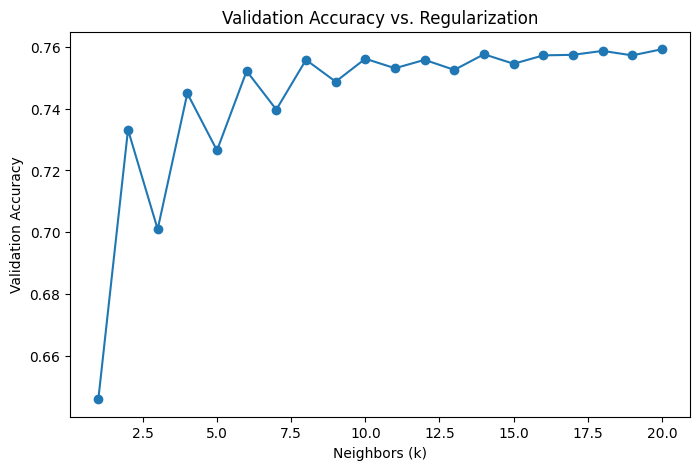

Best number of neighbors based on validation set: 20


In [39]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

neighbors_range = range(1, 21)
val_accuracies = []

for k in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    val_accuracies.append(knn.score(X_val, y_val))

# Plotting accuracy vs. regularization (k)
plt.figure(figsize=(8, 5))
plt.plot(neighbors_range, val_accuracies, marker='o', linestyle='-')
plt.title('Validation Accuracy vs. Regularization')
plt.xlabel('Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.show()

# Choose the best k
best_k = neighbors_range[val_accuracies.index(max(val_accuracies))]
print(f"Best number of neighbors based on validation set: {best_k}")

In [34]:
# Retrain on full training+validation set using best_k
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_val, y_train_val)
test_accuracy = knn_final.score(X_test, y_test)
print(f"Test Accuracy with best k={best_k}: {test_accuracy:.4f}")

Test Accuracy with best k=20: 0.7657


In [35]:
y_pred = knn_final.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4190   49]
 [1248   48]]
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      4239
           1       0.49      0.04      0.07      1296

    accuracy                           0.77      5535
   macro avg       0.63      0.51      0.47      5535
weighted avg       0.71      0.77      0.68      5535



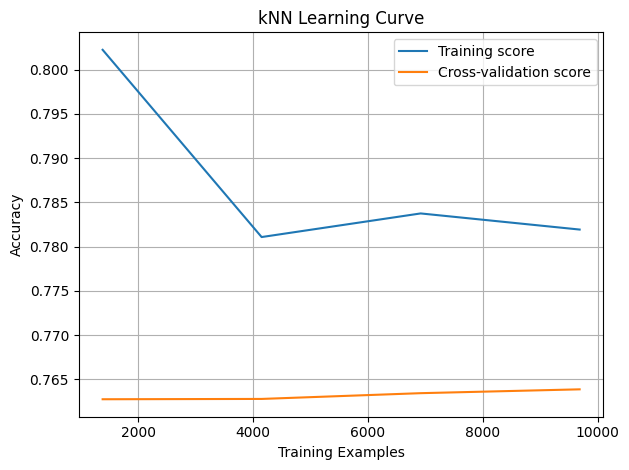

In [36]:
train_sizes, train_scores, test_scores = learning_curve(
    knn_final, X, y, 
    cv=2,  # Minimal CV folds
    scoring='accuracy', 
    train_sizes=[0.1, 0.3, 0.5, 0.7],  # Fewer, specific sizes
    n_jobs=1  # Single core
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("kNN Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

c:\Users\neelu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\neelu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\neelu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\neelu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\neelu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature na

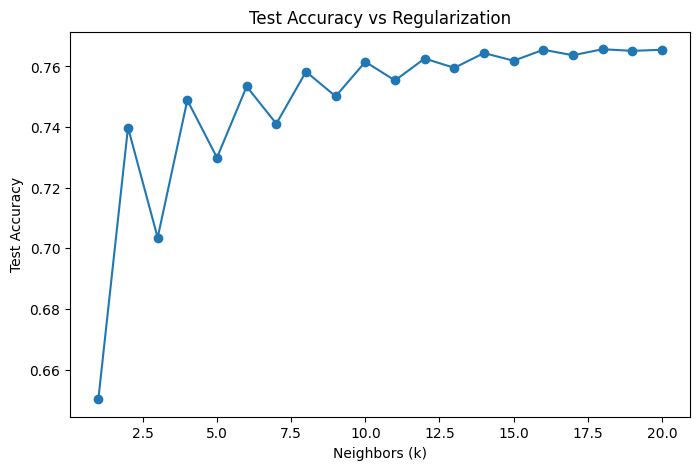

In [40]:
from sklearn.metrics import accuracy_score

X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

test_accuracies = []
k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_val, y_train_val)
    y_test_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(acc)

# Plot test accuracy vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, test_accuracies, marker='o', linestyle='-')
plt.title("Test Accuracy vs Regularization")
plt.xlabel("Neighbors (k)")
plt.ylabel("Test Accuracy")
plt.show()